In [1]:
#!git clone https://github.com/elina22-hub/11785_SceneDetection_Quantization.git

In [2]:
#!pip install onnxruntime

In [3]:
# copy data to 11785 directory
#%cp unique-142p.zip 11785_SceneDetection_Quantization/

In [3]:
# set current path to github model path
%cd ./11785_SceneDetection_Quantization

/home/ubuntu/11785_SceneDetection_Quantization


In [101]:
#!unzip \*.zip

### This Notebook sets batch_size = 1 to find the 5 highest/average/lowest Reconstruction/KLD/Total Loss Images

In [4]:
# packages for Quantization
import os
import yaml
import onnx
import onnx.numpy_helper
import onnxruntime
import onnxruntime.quantization

# packages for loading the model
from model.beta_vae import *
import torch.utils.data 
from torchvision import datasets, transforms
import pdb
import torch.nn.functional as F
import torch
import numpy as np
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import shutil
import warnings

warnings.filterwarnings("ignore")

cuda = torch.cuda.is_available()
NUM_WORKERS = 4 if cuda else 0
DEVICE = torch.device("cuda" if cuda else "cpu")
BATCH_SIZE = 1
IMG_SIZE = 64

print(torch.__version__)
print(cuda)
print(NUM_WORKERS)
print(DEVICE)

1.8.1+cu111
False
0
cpu


In [6]:
# model hyperparameters (beta = 2)
with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

In [7]:
config

{'model_params': {'name': 'BetaVAE',
  'beta': 2,
  'in_channels': 3,
  'latent_dim': 10,
  'loss_type': 'H',
  'max_capacity': 25,
  'Capacity_max_iter': 10000,
  'image_height': 64,
  'image_width': 64,
  'hidden_dims': [32, 64, 128, 256, 512]},
 'exp_params': {'img_size': 64,
  'train_data_dir': './data_train',
  'val_data_dir': './data_val',
  'model_save_dir': './best_model',
  'batch_size': 256,
  'learning_rate': 0.002,
  'weight_decay': 0.0,
  'scheduler_gamma': 0.6,
  'max_epochs': 250,
  'manual_seed': 1265,
  'log_save_dir': './logs',
  'log_save_name': 'BetaVAE',
  'pic_save_dir': './scene_divergence_graph'}}

In [8]:
# load model
model = BetaVAE(**config['model_params'])
model_name = "Model_baseline"
model_path = "./best_model/" + model_name
checkpoint = torch.load(model_path, map_location="cpu")
model.load_state_dict(checkpoint['model_state_dict'])
# make sure setting the model to eval mode before exporting to ONNX
model.eval()

BetaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
    )
  )
  (fc_mu): Linear(in_features=2048, out_features=10, bias=True)
  (fc_var): Linear(in_features=2048, out_features=10, bias=True)
  (decoder_input): Linear(in_features=10, out_features=2048, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_paddin

### Data Processing (Run Only Once Unless Terminal Crash)

Notice: Unique images index is not continuous. Also, .DS_Store is in the imagefile, remove it

In [9]:
%pwd

'/home/ubuntu/11785_SceneDetection_Quantization'

In [10]:
# pick the validation set from unique 142p dataset
imagefile = os.listdir("unique-142p")
imageset = set(imagefile)
old_path = "./unique-142p"
new_path = "./unique-142p-valid/142p-image/"
data_dir = "./unique-142p-valid/"

In [11]:
# pick validation images
def get_valid_image_list(imagefile):
    """
    input: imagefile -> the unique-142p file
    return: valid_image_list -> image name list for validation
    """
    valid_image_list = []
    st_idx = 1
    ed_idx = 25947
    for image in imagefile:
        if image != ".DS_Store":
            idx = int(image[6:12])
            if st_idx <= idx <= ed_idx:
                valid_image_list.append(image)
    return valid_image_list

In [12]:
# create file and put it under another file name
def copy_valid_image(valid_image_list, old_path, new_path):
    # determine whether new path exists
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    for valid_image in valid_image_list:
        shutil.copyfile(os.path.join(old_path, valid_image), os.path.join(new_path, valid_image))

In [13]:
# get validation image list and put it under the corresponding directory
valid_image_list = get_valid_image_list(imagefile)
copy_valid_image(valid_image_list, old_path, new_path)

### DataLoader

In [13]:
def load_data(phase, data_dir):
    transform_list = data_transforms(phase)
    if phase == "train":
        dataset = datasets.ImageFolder(data_dir, transform=transform_list)
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
    else:
        dataset = datasets.ImageFolder(data_dir, transform=transform_list)
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=NUM_WORKERS)
    return dataset, data_loader
        
def data_transforms(phase):
    if phase == "train":
        transform = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                        transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8),
                                        transforms.ToTensor()])
    else:
        transform = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                        transforms.ToTensor()])
    return transform

In [14]:
# create validation dataloader
valid_dataset, valid_dataloader = load_data(phase="eval", data_dir=data_dir)
example_valid_input = next(iter(valid_dataloader))[0]
print("\nDetails of the validation dataset and data loader are below.\n")
print("Num Observations: {}\nNum Batches:\t  {}\nBatch Shape:\t  {}\nNum Classes:\t  {}".\
      format(len(valid_dataset), len(valid_dataloader), list(example_valid_input.shape), len(valid_dataset.classes)))


Details of the validation dataset and data loader are below.

Num Observations: 14196
Num Batches:	  14196
Batch Shape:	  [1, 3, 64, 64]
Num Classes:	  1


### Convert Pytorch model to ONNX model

In [15]:
# model path
onnx_model_file = "./onnx_model/"

In [16]:
if not os.path.exists(onnx_model_file):
    os.mkdir(onnx_model_file)

In [17]:
# convert pytorch model to ONNX model
onnx_model_path = onnx_model_file + model_name + "_batchsize=1" + ".onnx"     # float 32
qi_onnx_model_path = onnx_model_file + "QI-" + model_name + "_batchsize=1" + ".onnx"  # int 8
print(onnx_model_path)
print(qi_onnx_model_path)

./onnx_model/Model_baseline_batchsize=1.onnx
./onnx_model/QI-Model_baseline_batchsize=1.onnx


In [18]:
# input to the model (same shape as batch input shape), just put some random input in
x = torch.ones(1, 3, 64, 64)
# Export pytorch model as onnx model
torch.onnx.export(model, x, onnx_model_path, input_names=["input"], output_names=["output"], opset_version=11)

In [32]:
#!pip install --upgrade onnx

In [19]:
# load onnx model
onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)

### Quantize Float32 Model to Int8 Model

In [20]:
# per channel=True???
kwargs = {"op_types_to_quantize":     [],
          "per_channel":              True,
          "reduce_range":             False,
          "activation_type":          onnxruntime.quantization.QuantType.QUInt8,
          "weight_type":              onnxruntime.quantization.QuantType.QUInt8,
          "nodes_to_quantize":        [],
          "nodes_to_exclude":         [],
          "use_external_data_format": False}

onnxruntime.quantization.quantize_dynamic(onnx_model_path, qi_onnx_model_path, **kwargs)

In [21]:
# Compare model parameters size
onnx_size_mb   = os.path.getsize(onnx_model_path)/1e6
qi_onnx_size_mb = os.path.getsize(qi_onnx_model_path)/1e6

print("\nONNX model size (MB):     {:.2f}".format(onnx_size_mb))
print("\nQI-ONNX model size (MB):  {:.2f}".format(qi_onnx_size_mb))


ONNX model size (MB):     12.84

QI-ONNX model size (MB):  7.96


### Perform Inference on Input Images

In [22]:
class init_inference:
    def __init__(self, session):
        self.session = session
        
    def __call__(self, image):
        input_data = image.numpy()
        input_name  = self.session.get_inputs()[0].name
    
        return self.session.run(None, {input_name: input_data})

def mean_latency_fn(tqdm_dataloader):
    start = tqdm_dataloader.start_t
    stop = tqdm_dataloader.last_print_t
    n = tqdm_dataloader.n
    mean_latency = (stop - start)/n
    return mean_latency

def simple_table(data_multilist, x_label_list, y_label_list):
    for i in range(len(y_label_list)+1):
        if i == 0:
            row = ["\t"]
            row.extend(x_label_list)
            string = "\t".join(row)
        else:
            row = [y_label_list[i-1]]
            
            row.extend([format(x, ".6f") for x in data_multilist[i-1]])
            string = "\t".join(row)
            
        print(string)
        
    return None

def plot_statistic(x, y, title, x_label, y_label):

    label_pos = [i for i, _ in enumerate(x)]

    plt.figure(figsize=(12, 6))
    plt.bar(label_pos, x, color='black', width=0.8)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(label_pos, y)
    
    plt.show()
    
    return None

def valid_model(valid_dataloader, session):
    tqdm_dataloader = tqdm(valid_dataloader)
    inference = init_inference(session)
    #valid_loss = {'val_total_loss':0.0, 'val_recon_loss':0.0,'val_kld':0.0}
    len_data_loader = len(valid_dataloader)
    
    recon_loss_list = []
    kld_loss_list = []
    total_loss_list = []
    images_array_list = []
    reconst_images_array_list = []
    
    for _, (images, y) in enumerate(tqdm_dataloader):
        # images size -> shape(1, 3, 64, 64)
        results = inference(images)
        # covert results into tensor
        results_converted = []
        for result in results:
            result = torch.tensor(result)
            results_converted.append(result)
        loss = model.loss_function(*results_converted,M_N = 1.0/float(len_data_loader), batch_size=BATCH_SIZE)
        
        recon_loss = loss["recon_loss"].cpu().detach().numpy()
        kld_loss = loss["kld"].cpu().detach().numpy()
        total_loss = loss["total_loss"].cpu().detach().numpy()
        
        recon_loss_list.append(recon_loss)
        kld_loss_list.append(kld_loss)
        total_loss_list.append(total_loss)
        images_array_list.append(images)
        reconst_images_array_list.append(results_converted[0])

    return images_array_list, reconst_images_array_list, recon_loss_list, kld_loss_list, total_loss_list

In [23]:
ort_session = onnxruntime.InferenceSession(onnx_model_path)
images_array_list, reconst_images_array_list, recon_loss_list, kld_loss_list, total_loss_list = valid_model(valid_dataloader, ort_session)

  0%|          | 0/14196 [00:00<?, ?it/s]

In [24]:
qi_ort_session = onnxruntime.InferenceSession(qi_onnx_model_path)
qi_images_array_list, qi_reconst_images_array_list, qi_recon_loss_list, qi_kld_loss_list, qi_total_loss_list = valid_model(valid_dataloader, qi_ort_session)

  0%|          | 0/14196 [00:00<?, ?it/s]

In [25]:
# find highest/averge/lowest 5 reconstruction/kld/total loss (corresponding images)
def find_Kloss_images(images_list, loss_list, K, mode):
    """
    images_list: image_tensor_list -> type: list of tensors
    loss_list: loss list -> type: list of losses
    K: top K (highest/averge/lowest) loss
    mode: max/mid/min
    
    return: top K loss (the corresponding images tensor) -> type: list of tensors
    """
    images_tensor = torch.cat(images_list, dim=0)
    loss_array = np.array(loss_list)
    n = len(loss_list)
    
    assert n == len(images_tensor)
    assert n > K
    assert n >= 2
    
    # argsort (from min to max)
    sort_index = loss_array.argsort()
    if mode == "max":
        indices = sort_index[-K:][::-1]
    if mode == "mid":
        if n % 2 == 0:
            if K % 2 == 0:
                indices = sort_index[(n-K)//2 : (n+K)//2]
            else:
                indices = sort_index[(n-K)//2 : (n-K)//2 + K]
        else:
            if K % 2 == 0:
                indices = sort_index[n//2 - K//2 : n//2 + K//2]
            else:
                indices = sort_index[(n-K)//2 : (n+K)//2]
    if mode == "min":
        indices = sort_index[:K]
    
    indices = indices.copy()
    # get corresponding images
    return images_tensor[indices], indices

In [26]:
def plot_images(images_tensor):
    """
    images_tensor: tensor of images -> shape(B, C, H, W)
    return: plot of images
    """
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(images_tensor, padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show()

### Visualize Reconstructed Image (Float 32 vs Int 8)

Highest/Averge/Lowest Reconstruction/KLD/Total Loss, the corresponding image, visualize it

### Float 32 vs Int 8

**Reconstruction Loss**

In [29]:
def plot_images_comparison(images_list, reconst_images_list, qi_images_list, qi_reconst_images_list, loss_list, qi_loss_list):
    """
    Function that plots images comparing (float 32 and int 8 both original and reconstruct)
    """
    # convert list of tensor to tensor
    origin_images_tensor = torch.cat(images_list)
    origin_qi_images_tensor = torch.cat(qi_images_list)
    
    # highest/averge/lowest reconstrunction loss (reconstruct picture) -> float 32
    high5recons_images, high_indices = find_Kloss_images(reconst_images_list, loss_list, K=5, mode="max")
    mid5recons_images, mid_indices = find_Kloss_images(reconst_images_list, loss_list, K=5, mode="mid")
    min5recons_images, min_indices = find_Kloss_images(reconst_images_list, loss_list, K=5, mode="min")

    # highest/averge/lowest reconstrunction loss (reconstruct picture) -> int 8
    qi_high5recons_images, qi_high_indices = find_Kloss_images(qi_reconst_images_list, qi_loss_list, K=5, mode="max")
    qi_mid5recons_images, qi_mid_indices = find_Kloss_images(qi_reconst_images_list, qi_loss_list, K=5, mode="mid")
    qi_min5recons_images, qi_min_indices = find_Kloss_images(qi_reconst_images_list, qi_loss_list, K=5, mode="min")


    # highest/averge/lowest reconstrunction loss (original picture) -> float 32
    high5origin_images = origin_images_tensor[high_indices]
    mid5origin_images = origin_images_tensor[mid_indices]
    min5origin_images = origin_images_tensor[min_indices]

    # highest/averge/lowest reconstrunction loss (original quantized picture) -> int 8
    qi_high5origin_images = origin_qi_images_tensor[qi_high_indices]
    qi_mid5origin_images = origin_qi_images_tensor[qi_mid_indices]
    qi_min5origin_images = origin_qi_images_tensor[qi_min_indices]
    
    # plot original
    print("============= Original Images (Float 32) ===================")
    plot_images(high5origin_images)
    plot_images(mid5origin_images)
    plot_images(min5origin_images)
    
    print("============= Reconstruction Images (Float 32) ===================")
    plot_images(high5recons_images)
    plot_images(mid5recons_images)
    plot_images(min5recons_images)
    
    print("============= Original Images (Int 8) ===================")
    plot_images(qi_high5origin_images)
    plot_images(qi_mid5origin_images)
    plot_images(qi_min5origin_images)
    
    print("============= Reconstruction Images (Int 8) ===================")   
    plot_images(qi_high5recons_images)
    plot_images(qi_mid5recons_images)
    plot_images(qi_min5recons_images)
    

#### Visualize Images with Reconstruction Loss

============= Original Images (Float 32) ===================


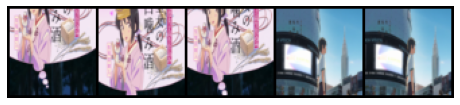

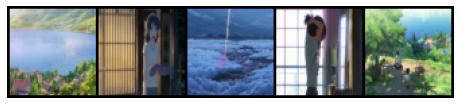

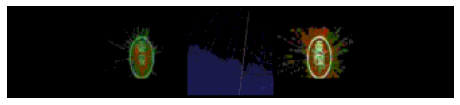

============= Reconstruction Images (Float 32) ===================


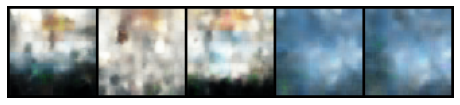

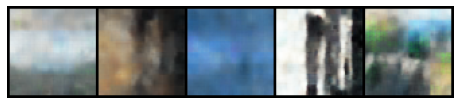

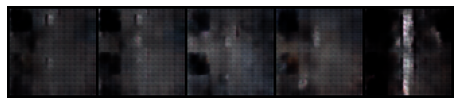

============= Original Images (Int 8) ===================


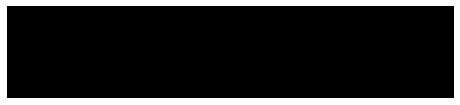

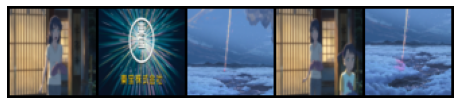

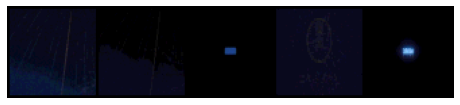

============= Reconstruction Images (Int 8) ===================


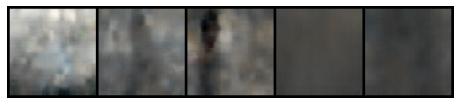

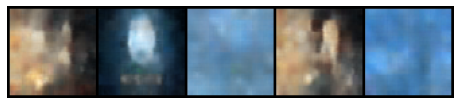

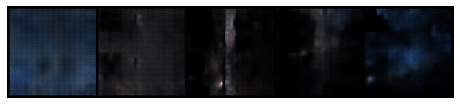

In [30]:
plot_images_comparison(images_array_list, reconst_images_array_list, qi_images_array_list, qi_reconst_images_array_list,
                      recon_loss_list, qi_recon_loss_list)

#### Visualize Images with KLD Loss

============= Original Images (Float 32) ===================


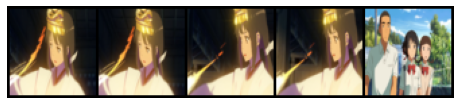

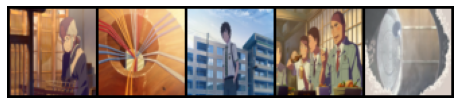

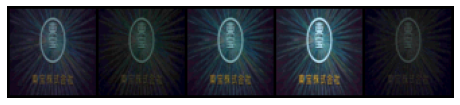

============= Reconstruction Images (Float 32) ===================


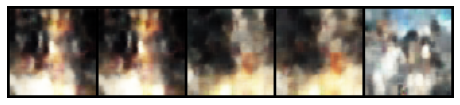

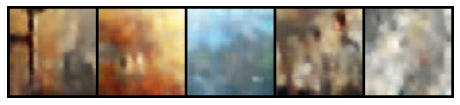

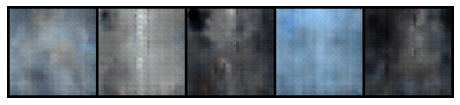

============= Original Images (Int 8) ===================


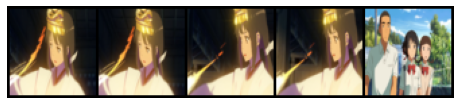

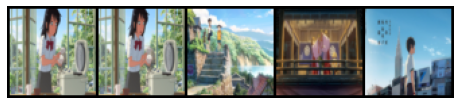

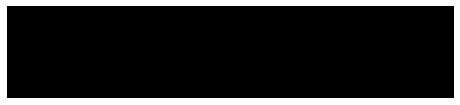

============= Reconstruction Images (Int 8) ===================


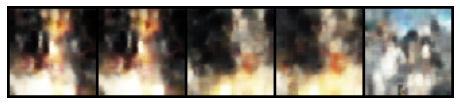

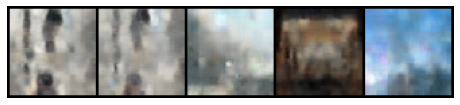

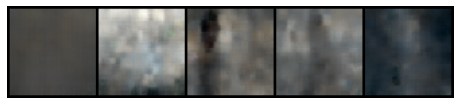

In [31]:
plot_images_comparison(images_array_list, reconst_images_array_list, qi_images_array_list, qi_reconst_images_array_list,
                      kld_loss_list, qi_kld_loss_list)

#### Visualize Images with Total Loss

============= Original Images (Float 32) ===================


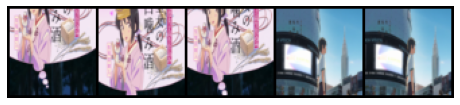

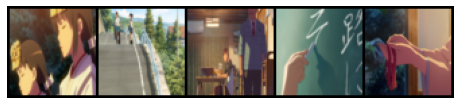

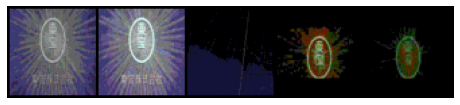

============= Reconstruction Images (Float 32) ===================


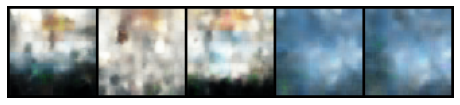

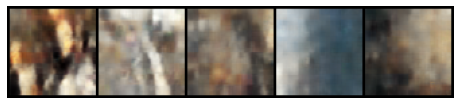

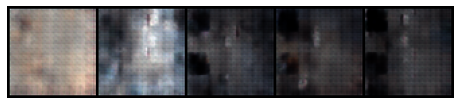

============= Original Images (Int 8) ===================


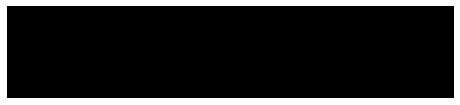

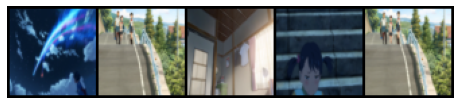

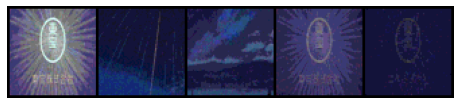

============= Reconstruction Images (Int 8) ===================


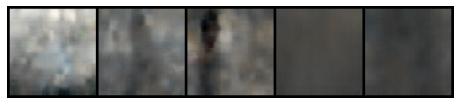

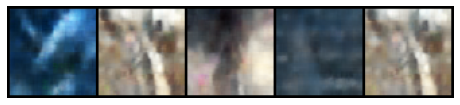

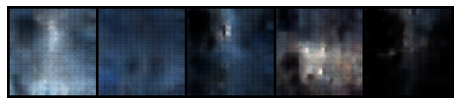

In [32]:
plot_images_comparison(images_array_list, reconst_images_array_list, qi_images_array_list, qi_reconst_images_array_list,
                      total_loss_list, qi_total_loss_list)

### Compare Accuracy of the scene change (Float 32 vs Int 8)

### Visualize Latent Space (Float 32 vs Int 8)